# TP 2: Reconstruction tomographique

In [3]:
import numpy as np
from IPython.display import Image

1.  Supposons, pour simplifier, que le corps humain est fait d’eau pure. Grâce à la base de
données XCOM du NIST , trouvez le µ de l’eau pour des photons de 60 keV, à une
masse volumique de 1.0 $\text{g}/\text{cm}^3$. Quelle fraction du signal subsiste après avoir traversé
5 cm d’eau ; 20 cm d’eau ?

In [4]:
def attenuation_after(distance, mu=2.059e-1):
    return np.exp(-mu*distance)

print(f"Atténuation après 5 cm : {attenuation_after(5)}")
print(f"Atténuation relative après 20 cm : {attenuation_after(20)}")

Atténuation après 5 cm : 0.35718550868274057
Atténuation relative après 20 cm : 0.016277035981532836


2. En utilisant le code fourni (ou pas), créer une rétroprojection simple, aussi appelée
laminogramme, des données de projection fournies. Notez qu’une approche par slicing
pourrait accélérer votre algorithme. Votre code utilisera la méthode du plus proche voisin
pour déterminer la valeur de projection à utiliser (le rayon passant par la source et le
voxel d’intérêt n’aboutit pas nécessairement au centre des pixels du détecteur).
Une fois que vous aurez accès au fantôme numérique, comparez-le à la reconstruction.
Qualitativement, quelles différences observez-vous entre l’image reconstruite et l’image
de référence (fantôme) ?

Le code pour le laminogramme est présenté ci-dessous. La méthode de reconstruction naive n'utilise aucun filtre pour isoler des zones de fréquences.

```python
[nbprj, angles, sinogram] = readInput()

    # initialiser une image reconstruite
    image = np.zeros((geo.nbvox, geo.nbvox))

    center_voxel = (geo.nbvox - 1) / 2
    center_pixel = (geo.nbpix - 1) / 2
    scale = geo.voxsize / geo.pixsize

    # "etaler" les projections sur l'image
    # ceci sera fait de façon "voxel-driven"
    # pour chaque voxel, trouver la contribution du signal reçu
    for j in range(geo.nbvox): # colonnes de l'image
        print("working on image column: "+str(j+1)+"/"+str(geo.nbvox))
        for i in range(geo.nbvox): # lignes de l'image
            x = j - center_voxel
            y = i - center_voxel
            for a in range(len(angles)):
                u = -x*np.cos(angles[a]) + y*np.sin(angles[a])
                u *= scale

                pixel_index = round(u + center_pixel)

                image[i, j] += sinogram[a, pixel_index]
```

Laminogram


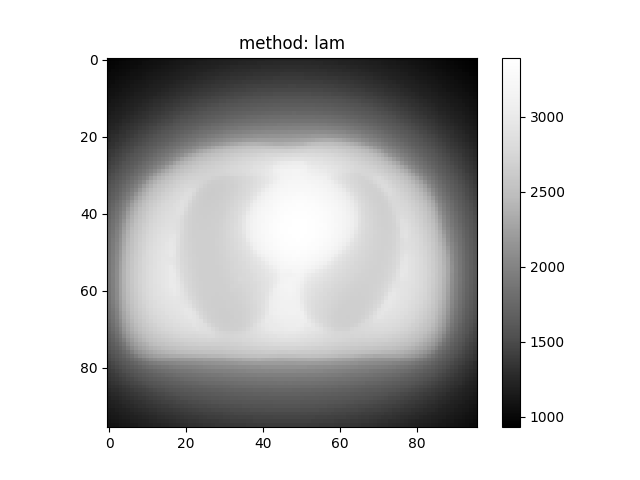


Phantom


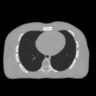

In [5]:
lam = Image("figs/lam-20250322-124449.png")
phantom = Image("figs/phantom-thorax-096-smooth.png")
print("Laminogram")
display(lam)
print()
print("Phantom")
display(phantom)

La différence majeure entre la reconstruction et le fantôme est le caractère flou de l'image reconstruite qui lui est absent du fantôme. Cet effet est attribuable au fait qu'aucune étape de filtrage est présente dans cet algorithme. Ainsi, la grande quantité de contenu à basses fréquences se retrouve dans la reconstruction finale.

3. En utilisant la librairie numpy.fft, implémentez le filtre passe-haut proposé pour filtrer
le sinogramme une projection à la fois. Affichez et sauvegardez l’image du sinogramme filtré. 
Qualitativement, quelles sont les principales différences entre le sinogramme fourni
et filtré ?

Le code responsable de filtrer le sinogramme est présenté ci-dessous. Le code implémente le filtre rampe en obtenant une liste de fréquences dont la longueur dépend de la taille d'une projection. En multipliant ce filtre avec la transformée de Fourier 1D d'une projection, on trouve une amplification augmentant de façon linéaire selon la fréquence.

```python
def filterSinogram(sinogram):
    for i in range(sinogram.shape[0]):
        sinogram[i] = filterLine(sinogram[i])

## filter une ligne (projection) via FFT
## filter une ligne (projection) via FFT
def filterLine(projection):
    # Obtenir la taille de la projection
    n = len(projection)
    
    # Calculer la FFT de la projection
    proj_fft = np.fft.fft(projection)
    
    # Créer un filtre rampe dans le domaine fréquentiel
    # Le filtre rampe est |f| où f est la fréquence
    freq = np.fft.fftfreq(n)
    ramp_filter = np.abs(freq)
    
    # Appliquer le filtre rampe
    filtered_proj_fft = proj_fft * ramp_filter
    
    # Calculer la transformée de Fourier inverse pour revenir au domaine spatial
    filtered_projection = np.real(np.fft.ifft(filtered_proj_fft))
    
    return filtered_projection
```

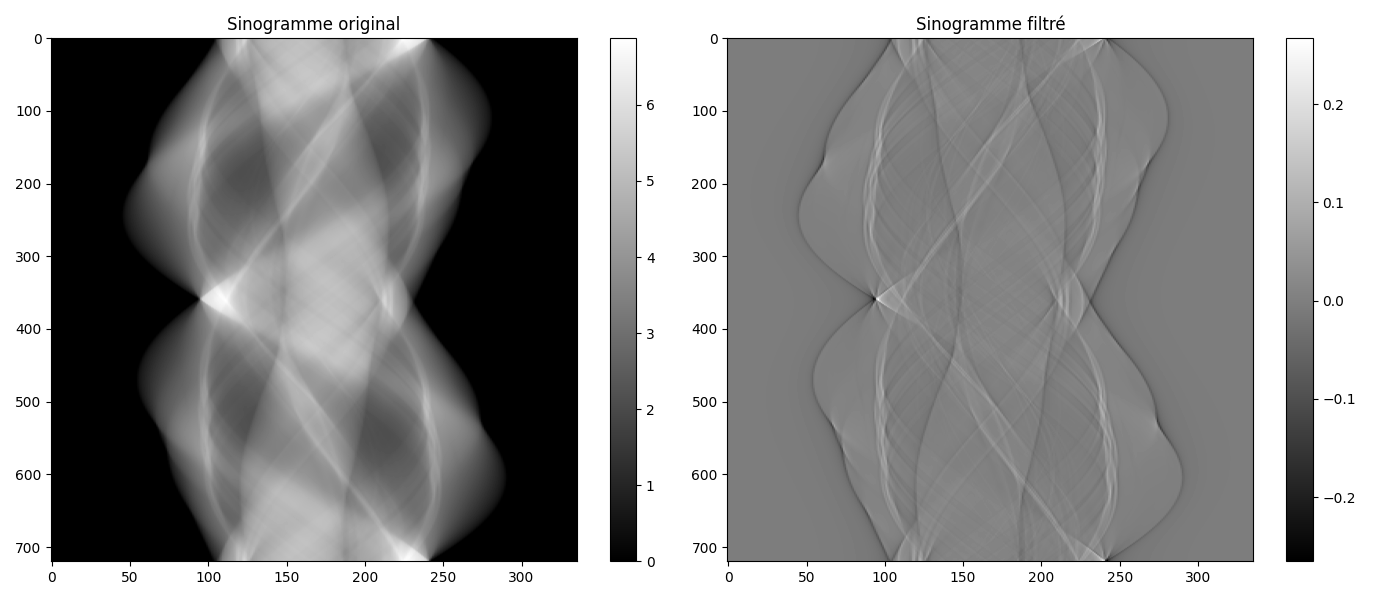

In [6]:
comparison = Image("figs/comparison_sinograms.png")
display(comparison)

- L'image reconstruite avec le filtre rampe présente une définition nettement supérieure avec des contours plus nets et des transitions d'intensité bien marquées. Cependant, on note également la présence accrue de bruit dans cette reconstruction. Ce phénomène est une conséquence directe de l'amplification des hautes fréquences par le filtre rampe, qui tout en améliorant la netteté des contours, amplifie également les composantes de bruit présentes dans les données.

- Il est intéressant de constater que l'image fournie dans les données de référence semble avoir subi un certain lissage (smoothing). Cette approche représente probablement un compromis délibéré entre la préservation des détails anatomiques importants et la suppression du bruit. Un tel équilibre pourrait avoir été obtenu en modifiant le filtre rampe standard, par exemple en appliquant une fenêtre d'apodisation (comme Hamming ou Hann) pour atténuer les plus hautes fréquences responsables de l'amplification du bruit.

- Cette observation illustre parfaitement le compromis classique en reconstruction tomographique entre résolution spatiale et niveau de bruit.

4. Ayant en main le sinogramme filtré, effectuez une rétroprojection filtrée, en récupérant idéalement le code précédent du laminogramme. Comparez l'image obtenue avec le fantôme. Quelles différences observez-vous ? Où sont situées les erreurs et que diriez-vous de la fréquence spatiale des erreurs ?

L'implémentation récupère le code utilisé pour le laminogramme. 

```python
[nbprj, angles, sinogram] = readInput()
    
    # initialiser une image reconstruite
    image = np.zeros((geo.nbvox, geo.nbvox))
    
    ### option filtrer ###
    CTfilter.filterSinogram(sinogram)
    ######
    center_voxel = (geo.nbvox - 1) / 2
    center_pixel = (geo.nbpix - 1) / 2
    scale = geo.voxsize / geo.pixsize
    # "etaler" les projections sur l'image
    # ceci sera fait de façon "voxel-driven"
    # pour chaque voxel, trouver la contribution du signal reçu
    for j in range(geo.nbvox): # colonnes de l'image
        print("working on image column: "+str(j+1)+"/"+str(geo.nbvox))
        for i in range(geo.nbvox): # lignes de l'image
            x = j - center_voxel
            y = i - center_voxel
            for a in range(len(angles)):
                u = -x*np.cos(angles[a]) + y*np.sin(angles[a])
                u *= scale

                pixel_index = round(u + center_pixel)

                #if 0 <= pixel_index < sinogram.shape[1]:
                image[i, j] += sinogram[a, pixel_index]
```

Filtered Backprojection


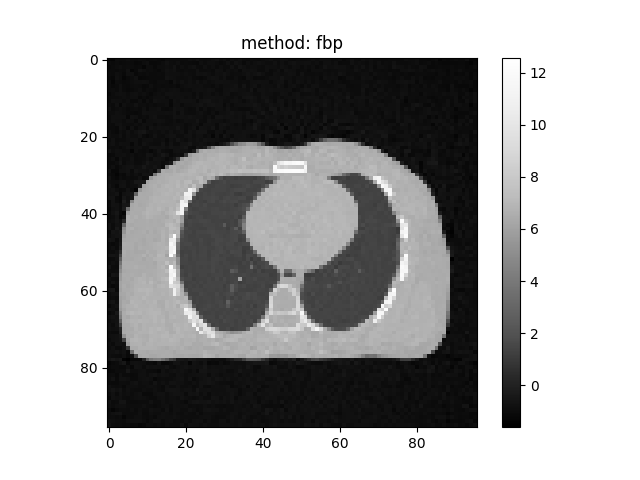


Phantom


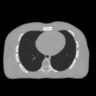

In [7]:
fbp = Image("figs/fbp-20250322-121453.png")
phantom = Image("figs/phantom-thorax-096-smooth.png")
print("Filtered Backprojection")
display(fbp)
print()
print("Phantom")
display(phantom)

Une comparaison direct entre les deux images permet de remarquer que l'image obtenue par rétroprojection filtrée est bruitée par rapport au fantôme. Il est facile de remarquer la présence de ce bruit dans les régions où le contraste est important, ce qui implique une fréquence élevée. L'amplification du bruit aux hautes fréquences est bien évidemment attendue puisqu'on utilise un filtre rampe. La rétroprojection filtrée est donc un compromis entre la quantité de détails dans le spécimen reconstruit et la quantité de bruit introduite par l'emploi d'un filtre.

5. Écrivez une nouvelle fonction de reconstruction ```reconFourierSlice()``` qui effectue la reconstruction via le théorème de la tranche de Fourier. Il faut effectuer la TF 1D de chaque projection du sinogramme et stocker le nouveau sinogramme transformé. Par échantillonage du sinogramme, remplissez l'espace de Fourier 2D de l'image à reconstruire. Vous pouvez choisir l'angle approprié par la méthode du plus proche voisin et la position sur le détecteur par interpolation linéaire. Trouvez l'image par $\mathrm{TF}_{2D}^{-1}$ et commentez les résultats. Indice : considérez toutes les données comme des nombres complexes avec l'initialisation suivante **mymatrix = numpy.zeros((a,b), "complex")**, puis prenez la partie réelle de l'image finale.

Voici l'implémentation du théorème de la tranche de Fourier pour la reconstruction tomographique. Ce code utilise la librairie *numpy* pour la création et la manipulation des arrays qui contiennent le sinogramme, les transformées de Fourier et la reconstruction finale. De plus, la librairie *scipy* est utilisée pour réaliser l'interpolation de la grille polaire se trouvant dans l'espace fréquentiel vers la grille cartésienne se trouvant dans l'espace temporel.

```python
[nbprj, angles, sinogram] = readInput()
dim = sinogram.shape[1] # nombre de projections et dimension de l'image finale
P = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sinogram, axes=1), axis=1), axes=1) # On fait la TF de
# chaque projections et on centre le DC (Freq=0)
P = P.ravel()

# grille polaire dans l'espace de Fourier
r = np.arange(dim) - dim / 2
r, a = np.meshgrid(r, angles)
r = r.ravel()
a = a.ravel()
srcx = (dim / 2) + r*np.cos(a)
srcy = (dim / 2) + r*np.sin(a)

# On construit une grille cartésienne qui servira pour l'interpolation
dstx, dsty = np.meshgrid(np.arange(dim), np.arange(dim))
dstx = dstx.ravel()
dsty = dsty.ravel()

# Interpolation par la méthode des "voisins proches" de la grille polaire vers la grille cartésienne 
fft2 = sp.interpolate.griddata((srcx, srcy), P, (dstx, dsty), method="nearest").reshape((dim, dim))
recon = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fft2)))) # Retour dans l'espace temporel,
# on fait la TF inverse 2D et on shift pour que le résultat s'affiche comme il faut
image = np.rot90(recon.T, -1) # On réoriente l'image reconstruite
```

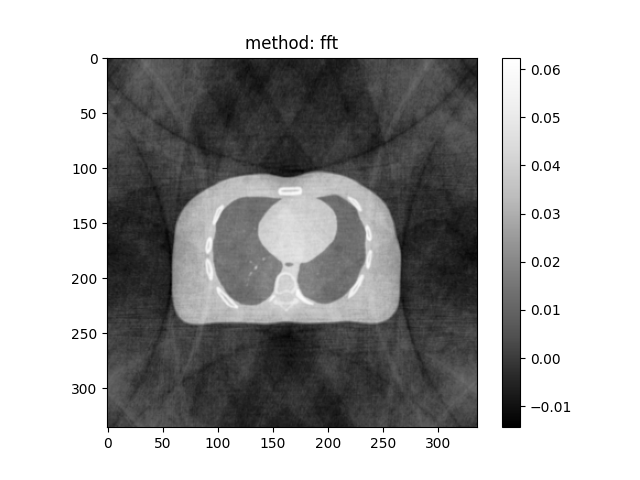

In [8]:
result = Image("figs/fft-20250322-112530.png")
display(result)

En observant l'image reconstruite, on constate immédiatement des artéfacts. Ceux-ci sont de basses fréquences puisqu'ils ne présentent aucun détails. En effet, l'absence de filtre dans cette méthode empêche d'éliminer les basses fréquences. Toutefois, la reconstruction du spécimen est assez fidèle même si il est possible de constater un manque de détail dans les régions où le contraste est important. En effet, selon [Kak et al.](https://www.mat.uniroma2.it/~picard/SMC/didattica/materiali_did/Anal.Armon./Principles_of_CT_Imaging/Kak&Slaney-CTI-reduced.pdf), la densité des points radiaux qui sont utilisés dans l'interpolation diminue plus la fréquence augmente, ceci limite donc la quantité de détails fins présents dans la reconstruction.